## Testing how runtime scales with number of phases in the composite

In [3]:
# Import necessary packages
import itertools
import json
import matplotlib.pyplot as plt
import numpy as np
import sys
import time

# Custom imports
sys.path.insert(1, '../core')
from optimization import HashinShtrikman
from user_input import MaterialProperty, Material, MixtureProperty, Mixture, UserInput

In [4]:
# Testing without calls to generate final dict (faster)
import json
consolidated_dict = {}
with open("consolidated_dict_02_11_2024_23_45_58") as f:
    consolidated_dict = json.load(f)

In [5]:
# Define the number of trials
num_trials = 10

## 2 phase composite

In [6]:
# Example material matches for an n=2 phase compositie
mat_1_ids = ["mp-1509", "mp-546266", "mp-12863", "mp-16290"]
mat_2_ids = ["mp-1509", "mp-546266", "mp-12863", "mp-16290"]
matches_dict = {'mat1': mat_1_ids, 'mat2': mat_2_ids}

In [7]:
# Need user input to create an HS instance
# Use same bounds for all materials
properties_mat_1 = [
    MaterialProperty(prop='elec_cond_300k_low_doping', upper_bound=20, lower_bound=1),
    MaterialProperty(prop='therm_cond_300k_low_doping', upper_bound=0.001, lower_bound=1e-5),
    MaterialProperty(prop='bulk_modulus', upper_bound=400, lower_bound=50),
    MaterialProperty(prop='shear_modulus', upper_bound=400, lower_bound=80),
    MaterialProperty(prop='universal_anisotropy', upper_bound=3, lower_bound=0.5),
]

# Define properties for the mixture
properties_mixture = [
    MixtureProperty(prop='elec_cond_300k_low_doping', desired_prop=9),
    MixtureProperty(prop='therm_cond_300k_low_doping', desired_prop=0.007),
    MixtureProperty(prop='bulk_modulus', desired_prop=234),
    MixtureProperty(prop='shear_modulus', desired_prop=150),
    MixtureProperty(prop='universal_anisotropy', desired_prop=1.5),
]

# Create Material & Mixture instances
mat_1 = Material(name='mat_1', properties=properties_mat_1)
mat_2 = Material(name='mat_2', properties=properties_mat_1)
mixture = Mixture(name='mixture', properties=properties_mixture)
aggregate = [mat_1, mat_2, mixture]

# Initialize UserInput instance with materials and mixtures
user_input= UserInput(materials=[mat_1, mat_2], mixtures=[mixture])
print("User Input: ", user_input)

User Input:  {'mat_1': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_2': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mixture': {'elec_cond_300k_low_doping': {'desired_prop': 9.0}, 'therm_cond_300k_low_doping': {'desired_prop': 0.007}, 'bulk_modulus': {'desired_prop': 234.0}, 'shear_modulus': {'desired_prop': 150.0}, 'universal_anisotropy': {'desired_prop': 1.5}}}


In [8]:
# Create an HS instance for testing
HS2 = HashinShtrikman(api_key="uJpFxJJGKCSp9s1shwg9HmDuNjCDfWbM", user_input=user_input)

2024-10-08 13:51:29,357 - custom_logger - INFO - Loading property categories from /Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Materials Project/hashin_shtrikman_mp/src/core/../io/inputs/mp_property_docs.yaml.
2024-10-08 13:51:29,373 - custom_logger - INFO - property_categories = ['carrier-transport', 'elastic']
2024-10-08 13:51:29,374 - custom_logger - INFO - mixture_props = {'elec_cond_300k_low_doping': {'desired_prop': 9.0}, 'therm_cond_300k_low_doping': {'desired_prop': 0.007}, 'bulk_modulus': {'desired_prop': 234.0}, 'shear_modulus': {'desired_prop': 150.0}, 'universal_anisotropy': {'desired_prop': 1.5}}


self.nuild_dict: <bound method UserInput.build_dict of {'mat_1': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_2': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mixture': {'elec_cond_300k_low_doping': {'desired_prop': 9.0}, 'therm_cond_300k_low_doping': {'desired_prop': 0.007}, 'bulk_modulus': {'desired_prop': 234.0}, 'shear_modulus': {'desired_prop': 150.0}, 'universal_anisotropy': {'desired_prop': 1.5}}

In [9]:
# Perform Optimizaztion several times to observe variation
HS2_times = []
for i in range(num_trials):
    start = time.time()
    HS2.set_HS_optim_params(gen_counter=False)
    end = time.time()
    HS2_time = end - start
    print(f'Trial {i}: {HS2_time} seconds')
    HS2_times.append(HS2_time)

Trial 0: 4.7692201137542725 seconds
Trial 1: 4.259726047515869 seconds
Trial 2: 3.5806758403778076 seconds
Trial 3: 4.666480779647827 seconds
Trial 4: 5.598827123641968 seconds
Trial 5: 4.091245889663696 seconds
Trial 6: 4.267436742782593 seconds
Trial 7: 4.0619401931762695 seconds
Trial 8: 4.224592208862305 seconds
Trial 9: 4.51829981803894 seconds


## 3 phase composite

In [10]:
# Example material matches for an n=3 phase compositie
mat_3_ids = ["mp-1509", "mp-546266", "mp-12863", "mp-16290"]
matches_dict = {'mat1': mat_1_ids, 'mat2': mat_2_ids, 'mat3': mat_3_ids}

In [11]:
# Need user input to create an HS instance
# Use same bounds for all materials

# Create Material & Mixture instances
mat_3 = Material(name='mat_3', properties=properties_mat_1)
mixture = Mixture(name='mixture', properties=properties_mixture)
aggregate = [mat_1, mat_2, mat_3, mixture]

# Initialize UserInput instance with materials and mixtures
user_input= UserInput(materials=[mat_1, mat_2, mat_3], mixtures=[mixture])
print("User Input: ", user_input)

User Input:  {'mat_1': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_2': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_3': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universa

In [12]:
# Create an HS instance for testing
HS3 = HashinShtrikman(api_key="uJpFxJJGKCSp9s1shwg9HmDuNjCDfWbM", user_input=user_input)

2024-10-08 13:52:13,470 - custom_logger - INFO - Loading property categories from /Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Materials Project/hashin_shtrikman_mp/src/core/../io/inputs/mp_property_docs.yaml.
2024-10-08 13:52:13,481 - custom_logger - INFO - property_categories = ['carrier-transport', 'elastic']
2024-10-08 13:52:13,484 - custom_logger - INFO - mixture_props = {'elec_cond_300k_low_doping': {'desired_prop': 9.0}, 'therm_cond_300k_low_doping': {'desired_prop': 0.007}, 'bulk_modulus': {'desired_prop': 234.0}, 'shear_modulus': {'desired_prop': 150.0}, 'universal_anisotropy': {'desired_prop': 1.5}}


self.nuild_dict: <bound method UserInput.build_dict of {'mat_1': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_2': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_3': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_boun

In [13]:
# Perform Optimizaztion several times to observe variation
HS3_times = []
for i in range(num_trials):
    start = time.time()
    HS3.set_HS_optim_params(gen_counter=False)
    end = time.time()
    HS3_time = end - start
    print(f'Trial {i}: {HS3_time} seconds')
    HS3_times.append(HS3_time)

Trial 0: 4.539283037185669 seconds
Trial 1: 4.104366064071655 seconds
Trial 2: 5.18105411529541 seconds
Trial 3: 4.043113946914673 seconds
Trial 4: 4.265689849853516 seconds
Trial 5: 4.145701169967651 seconds
Trial 6: 4.490874290466309 seconds
Trial 7: 4.1879730224609375 seconds
Trial 8: 4.249613046646118 seconds
Trial 9: 4.198256015777588 seconds


## 4 phase composite

In [14]:
# Example material matches for an n=3 phase compositie
mat_4_ids = ["mp-1509", "mp-546266", "mp-12863", "mp-16290"]
matches_dict = {'mat1': mat_1_ids, 'mat2': mat_2_ids, 'mat3': mat_3_ids, 'mat4': mat_4_ids}

In [15]:
# Need user input to create an HS instance
# Use same bounds for all materials

# Create Material & Mixture instances
mat_4 = Material(name='mat_4', properties=properties_mat_1)
mixture = Mixture(name='mixture', properties=properties_mixture)
aggregate = [mat_1, mat_2, mat_3, mat_4, mixture]

# Initialize UserInput instance with materials and mixtures
user_input= UserInput(materials=[mat_1, mat_2, mat_3, mat_4], mixtures=[mixture])
print("User Input: ", user_input)

User Input:  {'mat_1': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_2': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_3': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universa

In [16]:
# Create an HS instance for testing
HS4 = HashinShtrikman(api_key="uJpFxJJGKCSp9s1shwg9HmDuNjCDfWbM", user_input=user_input)

2024-10-08 13:52:56,938 - custom_logger - INFO - Loading property categories from /Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Materials Project/hashin_shtrikman_mp/src/core/../io/inputs/mp_property_docs.yaml.
2024-10-08 13:52:56,948 - custom_logger - INFO - property_categories = ['carrier-transport', 'elastic']
2024-10-08 13:52:56,950 - custom_logger - INFO - mixture_props = {'elec_cond_300k_low_doping': {'desired_prop': 9.0}, 'therm_cond_300k_low_doping': {'desired_prop': 0.007}, 'bulk_modulus': {'desired_prop': 234.0}, 'shear_modulus': {'desired_prop': 150.0}, 'universal_anisotropy': {'desired_prop': 1.5}}


self.nuild_dict: <bound method UserInput.build_dict of {'mat_1': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_2': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_3': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_boun

In [17]:
# Perform Optimizaztion several times to observe variation
HS4_times = []
for i in range(num_trials):
    start = time.time()
    HS4.set_HS_optim_params(gen_counter=False)
    end = time.time()
    HS4_time = end - start
    print(f'Trial {i}: {HS4_time} seconds')
    HS4_times.append(HS4_time)

Trial 0: 5.518813848495483 seconds
Trial 1: 4.916517972946167 seconds
Trial 2: 4.911646842956543 seconds
Trial 3: 4.679455041885376 seconds
Trial 4: 4.522457122802734 seconds
Trial 5: 4.717970848083496 seconds
Trial 6: 4.664383888244629 seconds
Trial 7: 4.75866174697876 seconds
Trial 8: 4.756370306015015 seconds
Trial 9: 4.885921001434326 seconds


## 5 phase composite

In [18]:
# Example material matches for an n=3 phase compositie
mat_5_ids = ["mp-1509", "mp-546266", "mp-12863", "mp-16290"]
matches_dict = {'mat1': mat_1_ids, 'mat2': mat_2_ids, 'mat3': mat_3_ids, 'mat4': mat_4_ids, 'mat5': mat_5_ids}

In [19]:
# Need user input to create an HS instance
# Use same bounds for all materials

# Create Material & Mixture instances
mat_5 = Material(name='mat_5', properties=properties_mat_1)
mixture = Mixture(name='mixture', properties=properties_mixture)
aggregate = [mat_1, mat_2, mat_3, mat_4, mat_5, mixture]

# Initialize UserInput instance with materials and mixtures
user_input= UserInput(materials=[mat_1, mat_2, mat_3, mat_4, mat_5], mixtures=[mixture])
print("User Input: ", user_input)

User Input:  {'mat_1': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_2': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_3': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universa

In [20]:
# Create an HS instance for testing
HS5 = HashinShtrikman(api_key="uJpFxJJGKCSp9s1shwg9HmDuNjCDfWbM", user_input=user_input)

2024-10-08 13:53:45,323 - custom_logger - INFO - Loading property categories from /Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Materials Project/hashin_shtrikman_mp/src/core/../io/inputs/mp_property_docs.yaml.
2024-10-08 13:53:45,329 - custom_logger - INFO - property_categories = ['carrier-transport', 'elastic']
2024-10-08 13:53:45,330 - custom_logger - INFO - mixture_props = {'elec_cond_300k_low_doping': {'desired_prop': 9.0}, 'therm_cond_300k_low_doping': {'desired_prop': 0.007}, 'bulk_modulus': {'desired_prop': 234.0}, 'shear_modulus': {'desired_prop': 150.0}, 'universal_anisotropy': {'desired_prop': 1.5}}


self.nuild_dict: <bound method UserInput.build_dict of {'mat_1': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_2': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_3': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_boun

In [21]:
# Perform Optimizaztion several times to observe variation
HS5_times = []
for i in range(num_trials):
    start = time.time()
    HS5.set_HS_optim_params(gen_counter=False)
    end = time.time()
    HS5_time = end - start
    print(f'Trial {i}: {HS5_time} seconds')
    HS5_times.append(HS5_time)

Trial 0: 5.207651138305664 seconds
Trial 1: 5.054834842681885 seconds
Trial 2: 5.119011878967285 seconds
Trial 3: 5.284974098205566 seconds
Trial 4: 5.735414028167725 seconds
Trial 5: 5.338562965393066 seconds
Trial 6: 5.257221937179565 seconds
Trial 7: 5.028254270553589 seconds
Trial 8: 5.394251108169556 seconds
Trial 9: 5.714440822601318 seconds


## 6 phase composite

In [22]:
# Example material matches for an n=3 phase compositie
mat_6_ids = ["mp-1509", "mp-546266", "mp-12863", "mp-16290"]
matches_dict = {'mat1': mat_1_ids, 
                'mat2': mat_2_ids, 
                'mat3': mat_3_ids, 
                'mat4': mat_4_ids, 
                'mat5': mat_5_ids, 
                'mat6': mat_6_ids}

In [23]:
# Need user input to create an HS instance
# Use same bounds for all materials

# Create Material & Mixture instances
mat_6 = Material(name='mat_6', properties=properties_mat_1)
mixture = Mixture(name='mixture', properties=properties_mixture)
aggregate = [mat_1, mat_2, mat_3, mat_4, mat_5, mat_6, mixture]

# Initialize UserInput instance with materials and mixtures
user_input= UserInput(materials=[mat_1, mat_2, mat_3, mat_4, mat_5, mat_6], mixtures=[mixture])
print("User Input: ", user_input)

User Input:  {'mat_1': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_2': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_3': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universa

In [24]:
# Create an HS instance for testing
HS6 = HashinShtrikman(api_key="uJpFxJJGKCSp9s1shwg9HmDuNjCDfWbM", user_input=user_input)

2024-10-08 13:54:38,507 - custom_logger - INFO - Loading property categories from /Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Materials Project/hashin_shtrikman_mp/src/core/../io/inputs/mp_property_docs.yaml.
2024-10-08 13:54:38,514 - custom_logger - INFO - property_categories = ['carrier-transport', 'elastic']
2024-10-08 13:54:38,514 - custom_logger - INFO - mixture_props = {'elec_cond_300k_low_doping': {'desired_prop': 9.0}, 'therm_cond_300k_low_doping': {'desired_prop': 0.007}, 'bulk_modulus': {'desired_prop': 234.0}, 'shear_modulus': {'desired_prop': 150.0}, 'universal_anisotropy': {'desired_prop': 1.5}}


self.nuild_dict: <bound method UserInput.build_dict of {'mat_1': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_2': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_3': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_boun

In [25]:
# Perform Optimizaztion several times to observe variation
HS6_times = []
for i in range(num_trials):
    start = time.time()
    HS6.set_HS_optim_params(gen_counter=False)
    end = time.time()
    HS6_time = end - start
    print(f'Trial {i}: {HS6_time} seconds')
    HS6_times.append(HS6_time)

Trial 0: 6.841414928436279 seconds
Trial 1: 6.386640787124634 seconds
Trial 2: 7.204782009124756 seconds
Trial 3: 7.208884000778198 seconds
Trial 4: 6.9093029499053955 seconds
Trial 5: 7.518507957458496 seconds
Trial 6: 7.659253358840942 seconds
Trial 7: 7.872366905212402 seconds
Trial 8: 9.016545057296753 seconds
Trial 9: 6.875351905822754 seconds


## 7 phase composite

In [26]:
# Example material matches for an n=3 phase compositie
mat_7_ids = ["mp-1509", "mp-546266", "mp-12863", "mp-16290"]
matches_dict = {'mat1': mat_1_ids, 
                'mat2': mat_2_ids, 
                'mat3': mat_3_ids, 
                'mat4': mat_4_ids, 
                'mat5': mat_5_ids, 
                'mat6': mat_6_ids,
                'mat7': mat_7_ids}

In [27]:
# Need user input to create an HS instance
# Use same bounds for all materials

# Create Material & Mixture instances
mat_7 = Material(name='mat_7', properties=properties_mat_1)
mixture = Mixture(name='mixture', properties=properties_mixture)
aggregate = [mat_1, mat_2, mat_3, mat_4, mat_5, mat_6, mat_7, mixture]

# Initialize UserInput instance with materials and mixtures
user_input= UserInput(materials=[mat_1, mat_2, mat_3, mat_4, mat_5, mat_6, mat_7], mixtures=[mixture])
print("User Input: ", user_input)

User Input:  {'mat_1': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_2': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_3': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universa

In [28]:
# Create an HS instance for testing
HS7 = HashinShtrikman(api_key="uJpFxJJGKCSp9s1shwg9HmDuNjCDfWbM", user_input=user_input)

2024-10-08 13:55:52,048 - custom_logger - INFO - Loading property categories from /Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Materials Project/hashin_shtrikman_mp/src/core/../io/inputs/mp_property_docs.yaml.
2024-10-08 13:55:52,200 - custom_logger - INFO - property_categories = ['carrier-transport', 'elastic']


self.nuild_dict: <bound method UserInput.build_dict of {'mat_1': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_2': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_3': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_boun

2024-10-08 13:55:52,244 - custom_logger - INFO - mixture_props = {'elec_cond_300k_low_doping': {'desired_prop': 9.0}, 'therm_cond_300k_low_doping': {'desired_prop': 0.007}, 'bulk_modulus': {'desired_prop': 234.0}, 'shear_modulus': {'desired_prop': 150.0}, 'universal_anisotropy': {'desired_prop': 1.5}}



material: mat_1, category: carrier-transport, property: 20.0
material: mat_1, category: carrier-transport, property: 0.001
material: mat_1, category: elastic, property: 400.0


In [29]:
# Perform Optimizaztion several times to observe variation
HS7_times = []
for i in range(num_trials):
    start = time.time()
    HS7.set_HS_optim_params(gen_counter=False)
    end = time.time()
    HS7_time = end - start
    print(f'Trial {i}: {HS7_time} seconds')
    HS7_times.append(HS7_time)

Trial 0: 7.228013038635254 seconds
Trial 1: 7.599699020385742 seconds
Trial 2: 7.015127182006836 seconds
Trial 3: 6.978771924972534 seconds
Trial 4: 6.980481863021851 seconds
Trial 5: 6.658699035644531 seconds
Trial 6: 6.23475193977356 seconds
Trial 7: 6.129540205001831 seconds
Trial 8: 6.020969390869141 seconds
Trial 9: 6.065483093261719 seconds


## 8 phase composite

In [30]:
# Example material matches for an n=3 phase compositie
mat_8_ids = ["mp-1509", "mp-546266", "mp-12863", "mp-16290"]
matches_dict = {'mat1': mat_1_ids, 
                'mat2': mat_2_ids, 
                'mat3': mat_3_ids, 
                'mat4': mat_4_ids, 
                'mat5': mat_5_ids, 
                'mat6': mat_6_ids,
                'mat7': mat_7_ids,
                'mat7': mat_7_ids}

In [31]:
# Need user input to create an HS instance
# Use same bounds for all materials

# Create Material & Mixture instances
mat_8 = Material(name='mat_8', properties=properties_mat_1)
mixture = Mixture(name='mixture', properties=properties_mixture)
aggregate = [mat_1, mat_2, mat_3, mat_4, mat_5, mat_6, mat_7, mat_8, mixture]

# Initialize UserInput instance with materials and mixtures
user_input= UserInput(materials=[mat_1, mat_2, mat_3, mat_4, mat_5, mat_6, mat_7, mat_8], mixtures=[mixture])
print("User Input: ", user_input)

User Input:  {'mat_1': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_2': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_3': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universa

In [32]:
# Create an HS instance for testing
HS8 = HashinShtrikman(api_key="uJpFxJJGKCSp9s1shwg9HmDuNjCDfWbM", user_input=user_input)

2024-10-08 13:56:59,215 - custom_logger - INFO - Loading property categories from /Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Materials Project/hashin_shtrikman_mp/src/core/../io/inputs/mp_property_docs.yaml.
2024-10-08 13:56:59,221 - custom_logger - INFO - property_categories = ['carrier-transport', 'elastic']
2024-10-08 13:56:59,222 - custom_logger - INFO - mixture_props = {'elec_cond_300k_low_doping': {'desired_prop': 9.0}, 'therm_cond_300k_low_doping': {'desired_prop': 0.007}, 'bulk_modulus': {'desired_prop': 234.0}, 'shear_modulus': {'desired_prop': 150.0}, 'universal_anisotropy': {'desired_prop': 1.5}}


self.nuild_dict: <bound method UserInput.build_dict of {'mat_1': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_2': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_3': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_boun

In [33]:
# Perform Optimizaztion several times to observe variation
HS8_times = []
for i in range(num_trials):
    start = time.time()
    HS8.set_HS_optim_params(gen_counter=False)
    end = time.time()
    HS8_time = end - start
    print(f'Trial {i}: {HS8_time} seconds')
    HS8_times.append(HS8_time)

Trial 0: 6.614459037780762 seconds
Trial 1: 6.513642072677612 seconds
Trial 2: 6.351125001907349 seconds
Trial 3: 6.523443222045898 seconds
Trial 4: 6.421319007873535 seconds
Trial 5: 6.818921089172363 seconds
Trial 6: 6.441033124923706 seconds
Trial 7: 6.412275075912476 seconds
Trial 8: 6.483538866043091 seconds
Trial 9: 6.553879022598267 seconds


## 9 phase composite

In [34]:
# Example material matches for an n=3 phase compositie
mat_9_ids = ["mp-1509", "mp-546266", "mp-12863", "mp-16290"]
matches_dict = {'mat1': mat_1_ids, 
                'mat2': mat_2_ids, 
                'mat3': mat_3_ids, 
                'mat4': mat_4_ids, 
                'mat5': mat_5_ids, 
                'mat6': mat_6_ids,
                'mat7': mat_7_ids,
                'mat7': mat_7_ids,
                'mat8': mat_8_ids,
                'mat9': mat_9_ids}

In [35]:
# Need user input to create an HS instance
# Use same bounds for all materials

# Create Material & Mixture instances
mat_9 = Material(name='mat_9', properties=properties_mat_1)
mixture = Mixture(name='mixture', properties=properties_mixture)
aggregate = [mat_1, mat_2, mat_3, mat_4, mat_5, mat_6, mat_7, mat_8, mat_9, mixture]

# Initialize UserInput instance with materials and mixtures
user_input= UserInput(materials=[mat_1, mat_2, mat_3, mat_4, mat_5, mat_6, mat_7, mat_8, mat_9], mixtures=[mixture])
print("User Input: ", user_input)

User Input:  {'mat_1': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_2': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_3': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universa

In [36]:
# Create an HS instance for testing
HS9 = HashinShtrikman(api_key="uJpFxJJGKCSp9s1shwg9HmDuNjCDfWbM", user_input=user_input)

2024-10-08 13:58:04,390 - custom_logger - INFO - Loading property categories from /Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Materials Project/hashin_shtrikman_mp/src/core/../io/inputs/mp_property_docs.yaml.
2024-10-08 13:58:04,399 - custom_logger - INFO - property_categories = ['carrier-transport', 'elastic']
2024-10-08 13:58:04,400 - custom_logger - INFO - mixture_props = {'elec_cond_300k_low_doping': {'desired_prop': 9.0}, 'therm_cond_300k_low_doping': {'desired_prop': 0.007}, 'bulk_modulus': {'desired_prop': 234.0}, 'shear_modulus': {'desired_prop': 150.0}, 'universal_anisotropy': {'desired_prop': 1.5}}


self.nuild_dict: <bound method UserInput.build_dict of {'mat_1': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_2': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_3': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_boun

In [37]:
# Perform Optimizaztion several times to observe variation
HS9_times = []
for i in range(num_trials):
    start = time.time()
    HS9.set_HS_optim_params(gen_counter=False)
    end = time.time()
    HS9_time = end - start
    print(f'Trial {i}: {HS9_time} seconds')
    HS9_times.append(HS9_time)

Trial 0: 6.952461004257202 seconds
Trial 1: 7.284000873565674 seconds
Trial 2: 6.899755001068115 seconds
Trial 3: 6.974318027496338 seconds
Trial 4: 6.837168216705322 seconds
Trial 5: 7.165256977081299 seconds
Trial 6: 6.855975866317749 seconds
Trial 7: 6.9338672161102295 seconds
Trial 8: 6.85993504524231 seconds
Trial 9: 7.279278755187988 seconds


## 10 phase composite

In [38]:
# Example material matches for an n=3 phase compositie
mat_10_ids = ["mp-1509", "mp-546266", "mp-12863", "mp-16290"]
matches_dict = {'mat1': mat_1_ids, 
                'mat2': mat_2_ids, 
                'mat3': mat_3_ids, 
                'mat4': mat_4_ids, 
                'mat5': mat_5_ids, 
                'mat6': mat_6_ids,
                'mat7': mat_7_ids,
                'mat7': mat_7_ids,
                'mat8': mat_8_ids,
                'mat9': mat_9_ids,
                'mat10': mat_10_ids}

In [39]:
# Need user input to create an HS instance
# Use same bounds for all materials

# Create Material & Mixture instances
mat_10 = Material(name='mat_10', properties=properties_mat_1)
mixture = Mixture(name='mixture', properties=properties_mixture)
aggregate = [mat_1, mat_2, mat_3, mat_4, mat_5, mat_6, mat_7, mat_8, mat_9, mat_10, mixture]

# Initialize UserInput instance with materials and mixtures
user_input= UserInput(materials=[mat_1, mat_2, mat_3, mat_4, mat_5, mat_6, mat_7, mat_8, mat_9, mat_10], mixtures=[mixture])
print("User Input: ", user_input)

User Input:  {'mat_1': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_2': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_3': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universa

In [40]:
# Create an HS instance for testing
HS10 = HashinShtrikman(api_key="uJpFxJJGKCSp9s1shwg9HmDuNjCDfWbM", user_input=user_input)

2024-10-08 13:59:14,477 - custom_logger - INFO - Loading property categories from /Users/carlabecker/Library/Mobile Documents/com~apple~CloudDocs/Carla's Desktop/UC Berkeley/Research/Materials Project/hashin_shtrikman_mp/src/core/../io/inputs/mp_property_docs.yaml.
2024-10-08 13:59:14,484 - custom_logger - INFO - property_categories = ['carrier-transport', 'elastic']
2024-10-08 13:59:14,484 - custom_logger - INFO - mixture_props = {'elec_cond_300k_low_doping': {'desired_prop': 9.0}, 'therm_cond_300k_low_doping': {'desired_prop': 0.007}, 'bulk_modulus': {'desired_prop': 234.0}, 'shear_modulus': {'desired_prop': 150.0}, 'universal_anisotropy': {'desired_prop': 1.5}}


self.nuild_dict: <bound method UserInput.build_dict of {'mat_1': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_2': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_bound': 400.0, 'lower_bound': 80.0}, 'universal_anisotropy': {'upper_bound': 3.0, 'lower_bound': 0.5}}, 'mat_3': {'elec_cond_300k_low_doping': {'upper_bound': 20.0, 'lower_bound': 1.0}, 'therm_cond_300k_low_doping': {'upper_bound': 0.001, 'lower_bound': 1e-05}, 'bulk_modulus': {'upper_bound': 400.0, 'lower_bound': 50.0}, 'shear_modulus': {'upper_boun

In [41]:
# Perform Optimizaztion several times to observe variation
HS10_times = []
for i in range(num_trials):
    start = time.time()
    HS10.set_HS_optim_params(gen_counter=False)
    end = time.time()
    HS10_time = end - start
    print(f'Trial {i}: {HS10_time} seconds')
    HS10_times.append(HS10_time)

Trial 0: 7.398499965667725 seconds
Trial 1: 7.704982757568359 seconds
Trial 2: 7.3908679485321045 seconds
Trial 3: 7.484270095825195 seconds
Trial 4: 7.41786003112793 seconds
Trial 5: 7.706705331802368 seconds
Trial 6: 7.406353950500488 seconds
Trial 7: 7.662090063095093 seconds
Trial 8: 7.654149055480957 seconds
Trial 9: 7.60999608039856 seconds


## Compare runtimes

In [42]:
runtimes = np.array([HS2_times, 
            HS3_times, 
            HS4_times, 
            HS5_times, 
            HS6_times, 
            HS7_times, 
            HS8_times, 
            HS9_times, 
            HS10_times])
phases = np.arange(len(runtimes)) + 2

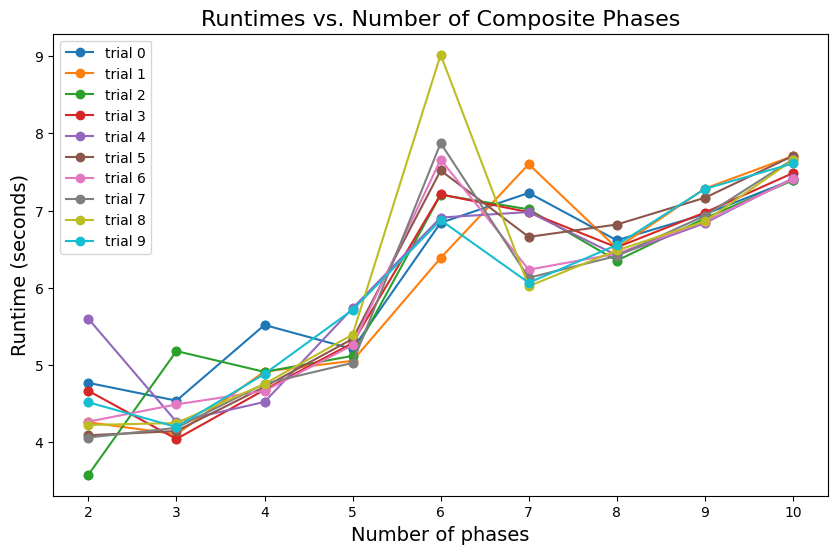

In [43]:
# Plot
plt.figure(figsize=(10, 6))

for i in range(num_trials):

    plt.plot(phases, runtimes[:, i], marker='o', linestyle='-', label=f'trial {i}')
    plt.scatter(phases, runtimes[:, i])

plt.xlabel('Number of phases', fontsize=14)
plt.ylabel('Runtime (seconds)', fontsize=14)
plt.title('Runtimes vs. Number of Composite Phases', fontsize=16)
plt.legend()

plt.show()

In [44]:
# Statistics
min_runtime = np.min(runtimes)
max_runtime = np.max(runtimes)
avg_runtime = np.mean(runtimes)
med_runtime = np.median(runtimes)

print(f'Min runtime: {min_runtime}')
print(f'Max runtime: {max_runtime}')
print(f'Average runtime: {avg_runtime}')
print(f'Median runtime: {med_runtime}')

Min runtime: 3.5806758403778076
Max runtime: 9.016545057296753
Average runtime: 5.999191104041206
Median runtime: 6.368882894515991
